# Part 2: Adaptation of TIMNet for Multimodal data

After initial implementation of the TIMNet model using only audio data, we now apply a multimodal dataset preprocessed by Poria et al. to the model. Textual features were extracted using convolutional neural networks (CNNs), while audio and visual features were derived using 3D-CNN and openSMILE, respectively.

In [3]:
import os
import sys
import copy
import pickle
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import keras.api._v2.keras as keras
import keras.backend as K
from keras.optimizers.legacy import Adam
from keras.optimizers import SGD
from keras import callbacks
from keras.models import Model
from keras.layers import Layer, Dense, Input, Activation, Lambda, BatchNormalization, Conv1D, SpatialDropout1D, add, GlobalAveragePooling1D
from keras.activations import sigmoid
from sklearn.model_selection import KFold
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
from data_utils import load_data

In [4]:
# Load multimodal data
train_data, train_label, test_data, test_label, train_text, train_audio, train_visual, test_text, test_audio, test_visual = load_data()

Max length of sequences:  110

Number of training samples: 120
Number of testing samples: 31

Train text shape: 120 samples, 110 timesteps, 100 features
Train audio shape: 120 samples, 110 timesteps, 100 features
Train visual shape: 120 samples, 110 timesteps, 512 features

Test text shape: 31 samples, 110 timesteps, 100 features
Test audio shape: 31 samples, 110 timesteps, 100 features
Test visual shape: 31 samples, 110 timesteps, 512 features



In [5]:
# TIM-Net Model

# Define Common Model class
class Common_Model(object):

    def __init__(self, save_path: str = '', name: str = 'Not Specified'):
        self.model = None
        self.trained = False 

    def train(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError()

    def predict(self, samples):
        raise NotImplementedError()

    def predict_proba(self, samples):
        if not self.trained:
            sys.stderr.write("No Model.")
            sys.exit(-1)
        return self.model.predict_proba(samples)

    def save_model(self, model_name: str):
        raise NotImplementedError()


def Temporal_Aware_Block(x, s, i, activation, nb_filters, kernel_size, dropout_rate=0, name=''):

    original_x = x
    #1.1
    conv_1_1 = Conv1D(filters=nb_filters, kernel_size=kernel_size,
                  dilation_rate=i, padding='causal')(x)
    conv_1_1 = BatchNormalization(trainable=True,axis=-1)(conv_1_1)
    conv_1_1 =  Activation(activation)(conv_1_1)
    output_1_1 =  SpatialDropout1D(dropout_rate)(conv_1_1)

    # 2.1
    conv_2_1 = Conv1D(filters=nb_filters, kernel_size=kernel_size,
                  dilation_rate=i, padding='causal')(output_1_1)
    conv_2_1 = BatchNormalization(trainable=True,axis=-1)(conv_2_1)
    conv_2_1 = Activation(activation)(conv_2_1)
    output_2_1 =  SpatialDropout1D(dropout_rate)(conv_2_1)
    
    if original_x.shape[-1] != output_2_1.shape[-1]:
        original_x = Conv1D(filters=nb_filters, kernel_size=1, padding='same')(original_x)
        
    output_2_1 = Lambda(sigmoid)(output_2_1)
    F_x = Lambda(lambda x: tf.multiply(x[0], x[1]))([original_x, output_2_1])
    return F_x


class TIMNET:
    def __init__(self,
                 nb_filters=64,
                 kernel_size=2,
                 nb_stacks=1,
                 dilations=None,
                 activation = "relu",
                 dropout_rate=0.1,
                 return_sequences=True,
                 name='TIMNET'):
        self.name = name
        self.return_sequences = return_sequences
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.dilations = dilations
        self.nb_stacks = nb_stacks
        self.kernel_size = kernel_size
        self.nb_filters = nb_filters

        self.supports_masking = True
        self.mask_value=0.

        if not isinstance(nb_filters, int):
            raise Exception()

    def __call__(self, inputs, mask=None):
        if self.dilations is None:
            self.dilations = 8
        forward = inputs
        backward = K.reverse(inputs,axes=1)
        
        print("Input Shape=",inputs.shape)
        forward_convd = Conv1D(filters=self.nb_filters,kernel_size=1, dilation_rate=1, padding='causal')(forward)
        backward_convd = Conv1D(filters=self.nb_filters,kernel_size=1, dilation_rate=1, padding='causal')(backward)

        final_skip_connection = []
        
        skip_out_forward = forward_convd
        skip_out_backward = backward_convd
        
        for s in range(self.nb_stacks):
            for i in [2 ** i for i in range(self.dilations)]:
                skip_out_forward = Temporal_Aware_Block(skip_out_forward, s, i, self.activation,
                                                        self.nb_filters,
                                                        self.kernel_size, 
                                                        self.dropout_rate,  
                                                        name=self.name)
                skip_out_backward = Temporal_Aware_Block(skip_out_backward, s, i, self.activation,
                                                        self.nb_filters,
                                                        self.kernel_size, 
                                                        self.dropout_rate,  
                                                        name=self.name)
                
                temp_skip = add([skip_out_forward, skip_out_backward],name = "biadd_"+str(i))
                # temp_skip=GlobalAveragePooling1D()(temp_skip)
                # temp_skip=tf.expand_dims(temp_skip, axis=1)
                final_skip_connection.append(temp_skip)

        output_2 = final_skip_connection[0]
        for i, item in enumerate(final_skip_connection[1:]):
            output_2 = K.concatenate([output_2, item], axis=-1)
        x = output_2

        return x

def smooth_labels(labels, factor=0.1):
    # smooth the labels
    labels *= (1 - factor)
    labels += (factor / labels.shape[1])
    return labels

class WeightLayer(Layer):
    def build(self, input_shape):
        # This should match the number of features (last dimension of the input shape)
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[-1], 6), 
                                      initializer='uniform', 
                                      trainable=True)
        super(WeightLayer, self).build(input_shape)

    def call(self, x):
        # Perform matrix multiplication without reducing the temporal dimension
        # Assuming self.kernel is [features, output_dim] and x is [batch, timesteps, features]
        x = K.dot(x, self.kernel)
        # Now x should be [batch, timesteps, output_dim]
        return x

    def compute_output_shape(self, input_shape):
        # Preserving the temporal dimension and applying the kernel to the last dimension (features)
        return (input_shape[0], input_shape[1], self.output_dim)

def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex/K.sum(ex, axis=axis, keepdims=True)

In [15]:
class TIMNET_Model:
    def __init__(self, args, input_shape, class_label):
        self.args = args
        self.input_shape = input_shape
        self.num_classes = 5
        self.class_label = class_label
        self.model = None

    def create_model(self):
        inputs = Input(shape=self.input_shape)
        x = TIMNET(nb_filters=self.args.filter_size, kernel_size=self.args.kernel_size, 
                   nb_stacks=self.args.stack_size, dilations=self.args.dilation_size,
                   dropout_rate=self.args.dropout, activation=self.args.activation,
                   return_sequences=True)(inputs)
        
        x = WeightLayer()(x)
        predictions = Dense(self.num_classes, activation='softmax')(x)
        self.model = Model(inputs=inputs, outputs=predictions)
        self.model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=self.args.lr), 
                           metrics=['accuracy'])
        print("TIMNET Model creation completed.")

    def kfold_validation(self, x, y):
        kfold = KFold(n_splits=self.args.split_fold, shuffle=True, random_state=self.args.random_seed)
        fold_counter = 1

        total_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}

        for train_index, test_index in kfold.split(x):
            x_train, x_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]

            print(f"Training fold {fold_counter}...")
            self.create_model()
            self.model.fit(x_train, y_train, validation_data=(x_test, y_test),
                           batch_size=self.args.batch_size, epochs=self.args.epoch, verbose=1)

            # Evaluating the model
            y_pred = self.model.predict(x_test)
            y_pred_classes = np.argmax(y_pred, axis=-1)
            y_true_classes = np.argmax(y_test, axis=-1)

            mask = (y_true != 0) & (y_pred != 0)
            y_pred = y_pred[mask]
            y_true = y_true[mask]

            precision, recall, f1, _ = precision_recall_fscore_support(y_true_classes, y_pred_classes, average='weighted')
            accuracy = np.mean(y_pred_classes == y_true_classes)

            total_metrics['accuracy'].append(accuracy)
            total_metrics['precision'].append(precision)
            total_metrics['recall'].append(recall)
            total_metrics['f1_score'].append(f1)

            print(f"Fold {fold_counter} Metrics: Accuracy={accuracy}, Precision={precision}, Recall={recall}, F1-Score={f1}")
            fold_counter += 1

        avg_metrics = {k: np.mean(v) for k, v in total_metrics.items()}
        print("Average Metrics Across All Folds:", avg_metrics)

        # Cleanup
        K.clear_session()

    def train_and_test(self, x_train, y_train, x_test, y_test):
        self.create_model()  # Ensure the model is created and compiled
        self.model.fit(x_train, y_train, validation_data=(x_test, y_test),
                       batch_size=self.args.batch_size, epochs=self.args.epoch, verbose=1)
        self.evaluate(x_test, y_test)  # Call evaluate to compute metrics
        self.print_metrics()  # Call print_metrics to display the results

    def evaluate(self, x_test, y_test):
        predictions = self.model.predict(x_test)
        y_pred = np.argmax(predictions, axis=-1).flatten()
        y_true = np.argmax(y_test, axis=-1).flatten()

        mask = (y_true != 0) & (y_pred != 0)
        y_pred = y_pred[mask]
        y_true = y_true[mask]

        accuracy = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

        self.test_metrics =  {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'cm': confusion_matrix(y_true, y_pred)
        }

    def print_metrics(self):
        print("Test Metrics:")
        print(f"Accuracy: {self.test_metrics['accuracy']:.4f}")
        print(f"Precision: {self.test_metrics['precision']:.4f}")
        print(f"Recall: {self.test_metrics['recall']:.4f}")
        print(f"F1 Score: {self.test_metrics['f1_score']:.4f}")

        class_labels = ['hap', 'ang', 'sad', 'neu']
        print("Confusion Matrix:")
        plt.figure(figsize=(8,6))
        sns.heatmap(self.test_metrics['cm'], annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()


In [7]:
# Define and set parameters
class Args:
    def __init__(self):
        self.split_fold = 5
        self.random_seed = 16
        self.epoch = 10
        self.gpu = 0
        self.lr = 0.001
        self.beta1 = 0.93
        self.beta2 = 0.98
        self.batch_size = 32
        self.dropout = 0.1
        self.activation = 'relu'
        self.filter_size = 39
        self.dilation_size = 8 
        self.kernel_size = 2
        self.stack_size = 1

args = Args()
class_label = ['hap', 'ang', 'sad', 'neu']

Input Shape= (None, 110, 712)
TIMNET Model creation completed.
Epoch 1/10


2024-04-13 23:49:34.020041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 1.6082 - accuracy: 0.4910

2024-04-13 23:50:21.920421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 60s 10s/step - loss: 1.6082 - accuracy: 0.4910 - val_loss: 1.2713 - val_accuracy: 0.6235
Epoch 2/10
4/4 [==============================] - 16s 4s/step - loss: 0.9650 - accuracy: 0.8284 - val_loss: 1.0300 - val_accuracy: 0.7411
Epoch 3/10
4/4 [==============================] - 12s 3s/step - loss: 0.6671 - accuracy: 0.9209 - val_loss: 0.9704 - val_accuracy: 0.7710
Epoch 4/10
4/4 [==============================] - 8s 2s/step - loss: 0.5398 - accuracy: 0.9417 - val_loss: 0.9797 - val_accuracy: 0.7798
Epoch 5/10
4/4 [==============================] - 6s 1s/step - loss: 0.4820 - accuracy: 0.9502 - val_loss: 0.9964 - val_accuracy: 0.7938
Epoch 6/10
4/4 [==============================] - 7s 2s/step - loss: 0.4439 - accuracy: 0.9570 - val_loss: 1.0091 - val_accuracy: 0.7994
Epoch 7/10
4/4 [==============================] - 6s 2s/step - loss: 0.4242 - accuracy: 0.9592 - val_loss: 1.0148 - val_accuracy: 0.8079
Epoch 8/10
4/4 [==============================] 

2024-04-13 23:51:39.819609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 7s 7s/step
Test Metrics:
Accuracy: 0.6393
Precision: 0.6340
Recall: 0.6140
F1 Score: 0.6194
Confusion Matrix:


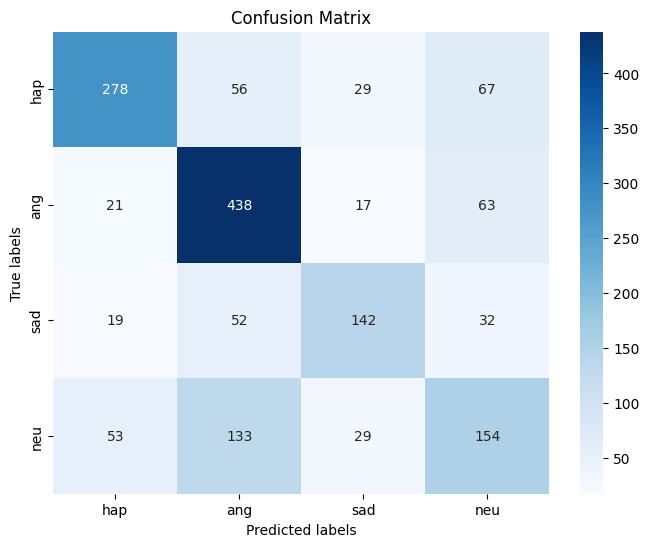

In [17]:
# Train and test with all data
timnet_multimodal = TIMNET_Model(args=args, input_shape=train_data.shape[1:], class_label=class_label)
timnet_multimodal.train_and_test(train_data, train_label, test_data, test_label)

Input Shape= (None, 110, 100)
TIMNET Model creation completed.
Epoch 1/10


2024-04-13 23:51:54.857107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 2.4585 - accuracy: 0.3139

2024-04-13 23:52:49.728007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 67s 13s/step - loss: 2.4585 - accuracy: 0.3139 - val_loss: 1.9731 - val_accuracy: 0.3487
Epoch 2/10
4/4 [==============================] - 17s 5s/step - loss: 1.4874 - accuracy: 0.4892 - val_loss: 1.5914 - val_accuracy: 0.4921
Epoch 3/10
4/4 [==============================] - 17s 4s/step - loss: 1.1205 - accuracy: 0.6537 - val_loss: 1.3392 - val_accuracy: 0.6255
Epoch 4/10
4/4 [==============================] - 17s 5s/step - loss: 0.8760 - accuracy: 0.7958 - val_loss: 1.1766 - val_accuracy: 0.7202
Epoch 5/10
4/4 [==============================] - 11s 3s/step - loss: 0.7301 - accuracy: 0.8765 - val_loss: 1.0894 - val_accuracy: 0.7648
Epoch 6/10
4/4 [==============================] - 8s 2s/step - loss: 0.6403 - accuracy: 0.9138 - val_loss: 1.0486 - val_accuracy: 0.7812
Epoch 7/10
4/4 [==============================] - 6s 2s/step - loss: 0.5715 - accuracy: 0.9333 - val_loss: 1.0339 - val_accuracy: 0.7877
Epoch 8/10
4/4 [==============================

2024-04-13 23:54:30.266141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 10s 10s/step
Test Metrics:
Accuracy: 0.6228
Precision: 0.6278
Recall: 0.5902
F1 Score: 0.5984
Confusion Matrix:


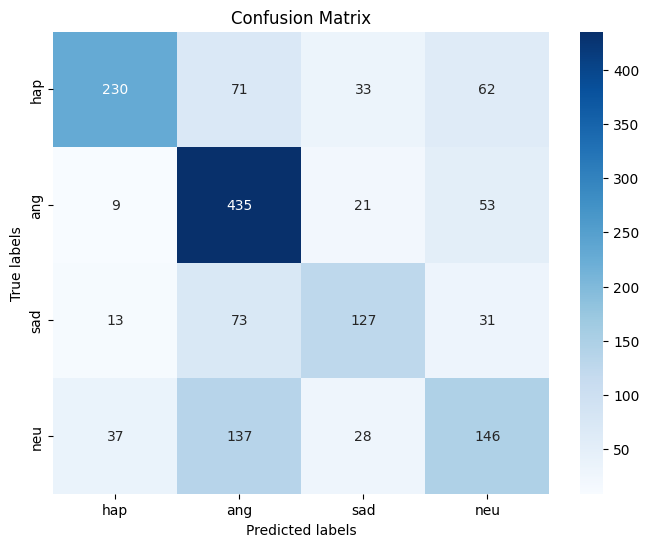

In [18]:
# Train and test for text data
timnet_text = TIMNET_Model(args=args, input_shape=train_text.shape[1:], class_label=class_label)
timnet_text.train_and_test(train_text, train_label, test_text, test_label)

Input Shape= (None, 110, 100)
TIMNET Model creation completed.
Epoch 1/10


2024-04-14 00:12:45.724941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 1.6007 - accuracy: 0.5434

2024-04-14 00:14:14.810294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 104s 21s/step - loss: 1.6007 - accuracy: 0.5434 - val_loss: 1.5858 - val_accuracy: 0.6660
Epoch 2/10
4/4 [==============================] - 22s 5s/step - loss: 1.5536 - accuracy: 0.7170 - val_loss: 1.5538 - val_accuracy: 0.6619
Epoch 3/10
4/4 [==============================] - 16s 4s/step - loss: 1.4988 - accuracy: 0.7102 - val_loss: 1.5133 - val_accuracy: 0.6598
Epoch 4/10
4/4 [==============================] - 13s 3s/step - loss: 1.4291 - accuracy: 0.7061 - val_loss: 1.4627 - val_accuracy: 0.6598
Epoch 5/10
4/4 [==============================] - 9s 2s/step - loss: 1.3535 - accuracy: 0.7061 - val_loss: 1.4045 - val_accuracy: 0.6619
Epoch 6/10
4/4 [==============================] - 8s 2s/step - loss: 1.2831 - accuracy: 0.7055 - val_loss: 1.3438 - val_accuracy: 0.6654
Epoch 7/10
4/4 [==============================] - 8s 2s/step - loss: 1.2088 - accuracy: 0.7159 - val_loss: 1.2862 - val_accuracy: 0.6683
Epoch 8/10
4/4 [==============================

2024-04-14 00:15:56.833643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 8s 8s/step
Test Metrics:
Accuracy: 0.4128
Precision: 0.1953
Recall: 0.3178
F1 Score: 0.2417
Confusion Matrix:


/Users/venessa/Desktop/5342project/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


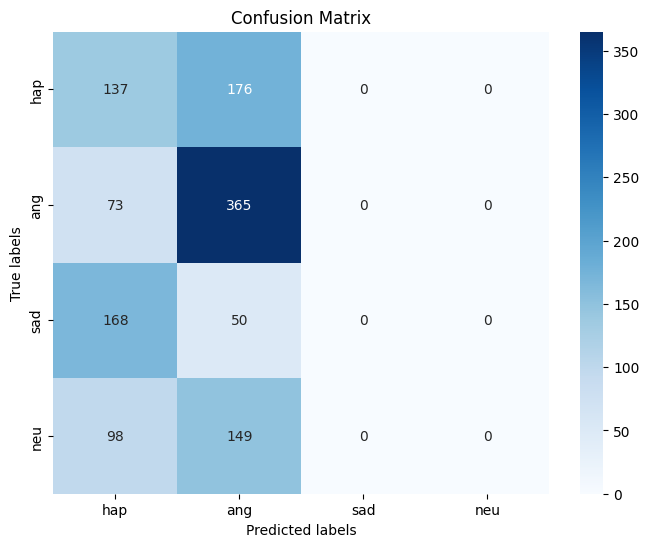

In [21]:
# Train and test for audio data
timnet_audio = TIMNET_Model(args=args, input_shape=train_audio.shape[1:], class_label=class_label)
timnet_audio.train_and_test(train_audio, train_label, test_audio, test_label)

Input Shape= (None, 110, 512)
TIMNET Model creation completed.
Epoch 1/10


2024-04-13 23:59:06.167654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 1.6036 - accuracy: 0.6299 

2024-04-14 00:01:16.951395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 154s 28s/step - loss: 1.6036 - accuracy: 0.6299 - val_loss: 1.5981 - val_accuracy: 0.6554
Epoch 2/10
4/4 [==============================] - 34s 8s/step - loss: 1.5856 - accuracy: 0.7076 - val_loss: 1.5836 - val_accuracy: 0.6540
Epoch 3/10
4/4 [==============================] - 23s 7s/step - loss: 1.5590 - accuracy: 0.7076 - val_loss: 1.5630 - val_accuracy: 0.6540
Epoch 4/10
4/4 [==============================] - 20s 5s/step - loss: 1.5192 - accuracy: 0.7082 - val_loss: 1.5349 - val_accuracy: 0.6545
Epoch 5/10
4/4 [==============================] - 22s 6s/step - loss: 1.4653 - accuracy: 0.7088 - val_loss: 1.4979 - val_accuracy: 0.6545
Epoch 6/10
4/4 [==============================] - 20s 5s/step - loss: 1.3966 - accuracy: 0.7096 - val_loss: 1.4513 - val_accuracy: 0.6545
Epoch 7/10
4/4 [==============================] - 12s 3s/step - loss: 1.3113 - accuracy: 0.7109 - val_loss: 1.3957 - val_accuracy: 0.6545
Epoch 8/10
4/4 [===========================

2024-04-14 00:04:15.654984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 18s 18s/step
Test Metrics:
Accuracy: 0.3510
Precision: 0.0878
Recall: 0.2500
F1 Score: 0.1299
Confusion Matrix:


/Users/venessa/Desktop/5342project/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


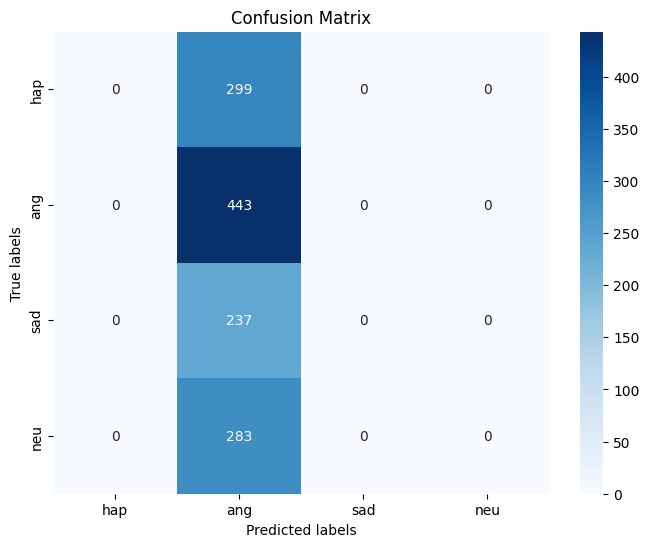

In [20]:
# Train and test for visual data
timnet_visual = TIMNET_Model(args=args, input_shape=train_visual.shape[1:], class_label=class_label)
timnet_visual.train_and_test(train_visual, train_label, test_visual, test_label)